## Convex Optimization HW3 : LASSO
### Name: Mohamed Amine HACHICHA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Define useful functions

In [2]:
def f0(v, Q, p):
    # returns the value of the objective function of the QP
    return v.T @ Q @ v + p.T @ v

def is_feasible(v, A, b):
    # Checks if v is feasible
    return max(A @ v - b) <= 0

def f_t(v, Q, p, b, A, t):
    # Create the barrier function
    if not is_feasible(v, A, b):
        return np.inf
    else:
        return t * (v.T @ Q @ v + p.T @ v) - sum(np.log(b - A @ v))

def grad_ft(v, Q, p, b, A, t):
    # Gradient of the barrier function
    return t * (2 * (Q @ v) + p) + (A/(b - A @ v).reshape(-1, 1)).sum(axis=0)

def hess_ft(v, Q, b, A, t):
    # Hessian of the barrier function
    hessian_terms = [(A[i].reshape(-1, 1) @ A[i].reshape(-1, 1).T)/(b[i]-A[i] @ v)**2 for i in range(A.shape[0])]
    return 2 * t * Q + np.sum(hessian_terms, axis = 0)

#### Implement *centering_step* and *berr_method* functions

In [3]:
def centering_step(Q, p, A, b, t, v, eps, alpha = 0.2, beta = 0.8):
    
    v_iterates = [v] # Contains the explored points during the centering step

    grad_ft_v = grad_ft(v, Q, p, b, A, t)
    hess_ft_v = hess_ft(v, Q, b, A, t)
    decrement_lambd = grad_ft_v @ np.linalg.inv(hess_ft_v) @ grad_ft_v # Newton decrement
    while (decrement_lambd/2 > eps):
        # Compute the newton step 
        delta_v = -np.linalg.inv(hess_ft_v) @ grad_ft_v

        # Do Backtracking line search
        r = 1
        while (f_t(v + r * delta_v, Q, p, b, A, t) > f_t(v, Q, p, b, A, t) + alpha * r * grad_ft_v.T @ delta_v):
            r = r * beta

        v = v + r * delta_v
        v_iterates.append(v)
        
        # Update the newton decrement
        grad_ft_v = grad_ft(v, Q, p, b, A, t)
        hess_ft_v = hess_ft(v, Q, b, A, t)
        decrement_lambd = grad_ft_v @ np.linalg.inv(hess_ft_v) @ grad_ft_v
        
    return v_iterates

In [4]:
def barr_method(Q, p, A, b, v0, eps, mu = 2, alpha = 0.2, beta = 0.8, t0 = 0.1):
    
    if not is_feasible(v0, A, b):
        raise ValueError('v0 is not strictly feasible')
    
    print('###########')
    print('Solving with mu = {}'.format(mu))
    
    t = t0
    m = len(b)
    
    v_arr_barrier = [v0] # Contains the explored points in outer iterations
    v_arr_newton = [v0]
    v = v0
    
    while (m/t > eps):
        t = t * mu
        v_newton = centering_step(Q, p, A, b, t, v, eps, alpha, beta)
        v = v_newton[-1]
        v_arr_barrier.append(v)
        #v_arr_newton += [v] * len(v_newton)
        v_arr_newton += v_newton
    
    print("Done")

    return v_arr_barrier, v_arr_newton


#### We simulate our data for fitting

In [5]:
n = 200 # Observations
m = 50 # Variables

# Simulate y = X.w + err
X = np.random.randn(n, m)
w = np.random.randn(m)
err = np.random.randn(n)
y = X @ w + err

# Quadratic problem inputs
Q = 0.5 * np.eye(n)
p = y
A = np.vstack((X.T, -X.T))
lambd = 10
b = lambd * np.ones(2 * m)

#### We run our optimizer on the simulated data. See PDF file, question 3, for the justification of how to recover w, i.e:   
$w_{predicted}=(X^TX)^{-1}X.(v_{fin}+y)$

In [6]:
eps = 1e-6
mu_s = [2, 5, 15, 50, 100]
w_predicted = {}
gaps_newton = {}
gaps_barrier = {}
exec_time = {}

for mu in mu_s:
    v0 = np.zeros(n)
    
    start_time = time.time()
    v_arr_barrier, v_arr_newton = barr_method(Q, p, A, b, v0, eps, mu, alpha=0.05, beta = 0.7, t0=1)
    duration = time.time() - start_time
    v_fin = v_arr_barrier[-1] # The final retained value v for minimizing f
    f_opt = f0(v_fin, Q, p) # Surrogate approximation of the optimal value f*
    
    # compute the corresponding predicted w (see report for justification)
    w_predicted[mu] = np.linalg.inv(X.T @ X) @ X.T @ (v_fin + y)

    # Compute gaps for newton steps
    gaps_newton[mu] = np.array([f0(v_, Q, p) - f_opt for v_ in v_arr_newton])
    
    # Compute gaps for outer iterations
    gaps_barrier[mu] = np.array([f0(v_, Q, p) - f_opt for v_ in v_arr_barrier])
    
    # Update the execution time
    exec_time[mu] = duration

###########
Solving with mu = 2
Done
###########
Solving with mu = 5
Done
###########
Solving with mu = 15
Done
###########
Solving with mu = 50
Done
###########
Solving with mu = 100
Done


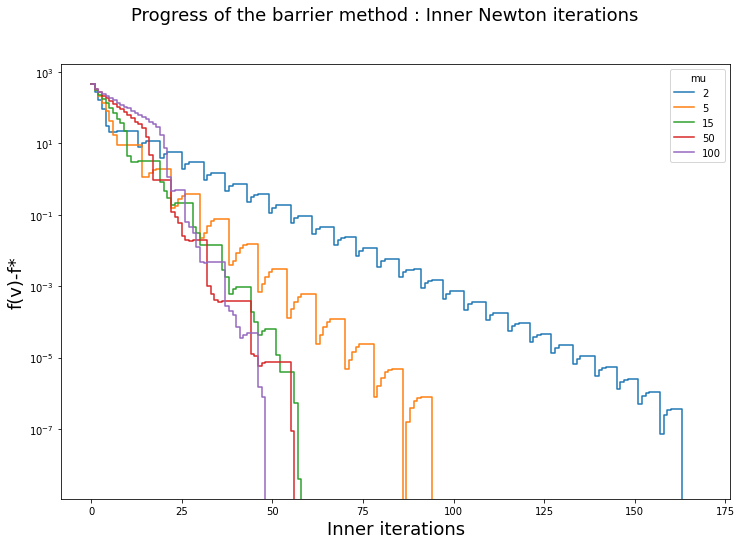

In [7]:
fig1 = plt.figure(figsize=(12, 8))
plt.suptitle('Progress of the barrier method : Inner Newton iterations', size=18)
for mu in mu_s:
    n_iter = len(gaps_newton[mu])
    plt.step(range(n_iter), y=gaps_newton[mu], label = mu)
plt.yscale('log')
plt.xlabel('Inner iterations', size=18)
plt.ylabel('f(v)-f*', size=18)
plt.legend(title='mu')
plt.show()

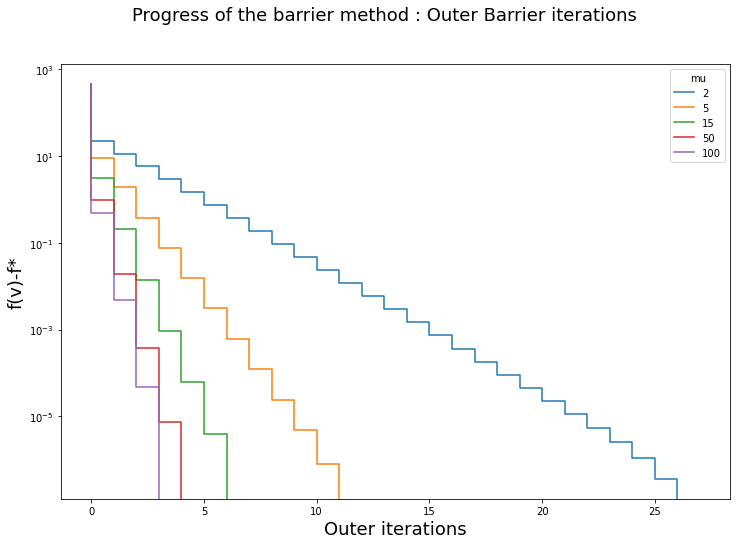

In [8]:
fig2 = plt.figure(figsize=(12, 8))
plt.suptitle('Progress of the barrier method : Outer Barrier iterations', size=18)
for mu in mu_s:
    n_iter = len(gaps_barrier[mu])
    plt.step(range(n_iter), y=gaps_barrier[mu], label = mu)
plt.yscale('log')
plt.xlabel('Outer iterations', size=18)
plt.ylabel('f(v)-f*', size=18)
plt.legend(title='mu')
plt.show()

### As expected with the barrier method, the number of needed iterations increases when $\mu$ decreases.
### The algorithm with $\mu = 100$ needs the fewest newton steps and outer iterations.
### We need roughly the same number of inner iterations with $\mu=15$ and $\mu=50$ even though they need more outer steps than with $\mu=100$. 
### This shows that when $\mu$ increases, we perform less outer iterations but each outer iteration needs more inner iterations to converge.

In [9]:
print('---------- Execution times ----------')
for mu in mu_s:
    print('For mu = {} : {}'.format(mu, str(exec_time[mu])[:4] + ' sec'))


print('---------- Deviations from w ----------')
deviation = {}

for mu in mu_s:
    deviation[mu] = np.linalg.norm(w_predicted[mu] - w)/np.linalg.norm(w)
    print('Deviation for mu = {} : {}'.format(mu, deviation[mu]))

---------- Execution times ----------
For mu = 2 : 21.0 sec
For mu = 5 : 12.1 sec
For mu = 15 : 7.15 sec
For mu = 50 : 7.17 sec
For mu = 100 : 6.54 sec
---------- Deviations from w ----------
Deviation for mu = 2 : 0.10155547463652152
Deviation for mu = 5 : 0.1015554748095288
Deviation for mu = 15 : 0.1015554747189281
Deviation for mu = 50 : 0.10155547485575567
Deviation for mu = 100 : 0.10155547450493232


#### We notice that the fastest resolution is with $\mu = 100$ in terms of execution time. The deviations show that we get almost the same predicted $w$ for every $\mu$. Therefore, an appropriate choice of $\mu$ would be 100 : faster resolution with the same precision.

### Finally we compare our solution $v_{final}$ to the solution given by the cvxopt library's solver

In [10]:
from cvxopt import matrix
from cvxopt import solvers
P = matrix(2*Q)
q = matrix(p)
G = matrix(A)
h = matrix(b)

sol = solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0: -1.0242e+02 -2.3423e+03  2e+03  9e-16  2e-14
 1: -2.7440e+02 -5.9689e+02  3e+02  8e-16  2e-15
 2: -4.4031e+02 -4.8275e+02  4e+01  8e-16  7e-16
 3: -4.6666e+02 -4.6973e+02  3e+00  1e-15  2e-15
 4: -4.6856e+02 -4.6866e+02  1e-01  1e-15  6e-15
 5: -4.6862e+02 -4.6862e+02  5e-03  1e-15  1e-13
 6: -4.6862e+02 -4.6862e+02  2e-04  1e-15  2e-12
Optimal solution found.


In [11]:
v_solver = np.array(sol['x']).reshape(1,-1)[0]

diff = np.linalg.norm(v_solver-v_fin)/np.linalg.norm(v_solver)
print(diff)

0.0001904310203659868


### The difference between the two solutions is negligible. Our solver converges then to the same solution as the cvxopt library's solution